In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cmath import phase, polar
from scipy.special import jv as besselj
from scipy.special import hankel2 as besselh

from scipy.optimize import fsolve
from math import cos, pi, e

from scipy.integrate import simps
from scipy.signal import find_peaks

np.random.seed(0)

from importlib import reload  
import asym_shell_help_func
reload(asym_shell_help_func)
    
from asym_shell_help_func import get_coefficients, get_refractive_index

%matplotlib inline

# Parameters

In [2]:
plasmonic_metal = 'silver'
#structure 
r_ext = 100 # external radius in nm
r_int = 70  # internal radius in nm
dist_between_centers=0 # (nm)

# parameters of incident wave 
lyambda= 428 # wavelength in nm
alpha_incident = pi / 2 # angle of incidence


In [3]:
# normalization 
r0=r_ext # radius (nm)

w0_incident=2*pi*r_ext/lyambda

h_ratio = r_int / r_ext
dist_btw_centers = dist_between_centers / r_ext

# system truncation number
N_truncation_number = 15

In [4]:
n_value, k_value = get_refractive_index(lyambda, plasmonic_metal)
n_plasma_refr_index = n_value - 1.j * k_value

In [5]:
a_m, b_m, c_m, d_m= get_coefficients(w0_incident, n_plasma_refr_index, h_ratio, alpha_incident, N_truncation_number, dist_btw_centers)
if a_m == []:
    print('The system does not converge for this parameters')

In [11]:
num_of_points = 500
xy = np.linspace(-3, 3, num=num_of_points)

x1, y1 = np.meshgrid(xy, xy)
y1 = -y1 
Z = np.zeros((num_of_points, num_of_points), dtype=complex)


In [12]:
def get_field_core(w0, a_, N, r, phi):
    res = 0
    for m in range(-N, N + 1):
        a = a_[m + N]
        res = res + a * besselj(m,w0*r) * e**(1.j *m * phi)
    return res

In [13]:
def get_field_shell(w0, n, b_, c_, N, r1, phi1, r2, phi2):
    res = 0
    for m in range(-N, N + 1):
        b = b_[m + N]
        res = res + b * besselj(m,n*w0*r1) * e**(1.j *m * phi1)
        
    for m in range(-N, N + 1):
        c = c_[m + N]
        res = res + c * besselh(m,n*w0*r2) * e**(1.j *m * phi2)
    
    return res

In [14]:
def get_field_out(w0, d_, N, r, phi, alpha):
    res = 0
    for m in range(-N, N+1):
        d = d_[m + N]
        H = d * besselh(m, w0*r) * e**(1.j *m * phi) + (-1.j) ** m * besselj(m, w0*r) *  e**(1.j *m * (phi - alpha))
        res = res + H 
    
    return res

In [ ]:
if a_m != []:
    for i in range(xy.size):
        for j in range(xy.size):
            if ((x1[i][j] - dist_btw_centers)**2 + y1[i][j]**2 > h_ratio**2) and (x1[i][j]**2 + y1[i][j]**2 < 1):
                r1, phi1 = polar(complex(x1[i,j], y1[i,j]))
                r2, phi2 = polar(complex(x1[i,j] - dist_btw_centers, y1[i,j]))
                Z[i, j]= get_field_shell(w0_incident, n_plasma_refr_index, b_m, c_m, N_truncation_number, r1, phi1, r2, phi2)

            if ((x1[i][j] - dist_btw_centers)**2 + y1[i][j]**2 <= h_ratio**2):
                r2, phi2 = polar(complex(x1[i,j] - dist_btw_centers, y1[i,j]))
                Z[i, j]=get_field_core(w0_incident, a_m, N_truncation_number, r2, phi2)

            if (x1[i][j]**2 + y1[i][j]**2 >= 1):
                r1, phi1 = polar(complex(x1[i,j], y1[i,j]))
                Z[i, j] =get_field_out(w0_incident, d_m, N_truncation_number, r1, phi1, alpha_incident)

    fig = plt.figure(figsize = (3, 3), dpi = 100)
    ax = plt.contourf(x1,y1,1000 *abs(Z.real))
    circle1 = plt.Circle((dist_btw_centers, 0),h_ratio, color='white', fill = False)
    circle2= plt.Circle((0, 0),1, color='white', fill = False)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().set_aspect('equal', adjustable='box')
#     plt.colorbar()
    plt.axis('off')
#     plt.show() 
#     plt.savefig('figures/near_field_r_ext_'+ str(r_ext) +'_r_int_' + str(r_int)+ '_lambda_' + str(lyambda)+ '.jpg', dpi = 100)

In [23]:
xy.shape

(200,)

# Far Field

In [24]:
def get_far_field(d_, w0, N, phi, d):
    res = 0
    for m in range(-N, N + 1):
       
        d = d_[m + N]
        temp = d * e**(1.j*m*phi) * 1.j**m
        res = res + temp
    
    return res

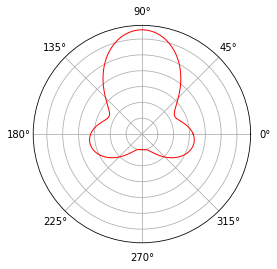

In [25]:
if a_m != []:
    phi = np.linspace(0, 2*pi, num=360)
    YY = []
    for i in range(len(phi)):
        S = get_far_field(d_m, w0_incident, N_truncation_number, phi[i], dist_btw_centers)    
        YY.append(abs(S))
    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='polar')
    ax.plot(phi, YY, color='r', linewidth=1)
    ax.set_yticklabels([])

#     plt.show()
#     plt.savefig('figures/far_field_ext_'+ str(r_ext) +'_r_int_' + str(r_int)+ '_lambda_' + str(lyambda)+ '.jpg', dpi = 100)

# SCS

Text(0, 0.5, 'SCS')

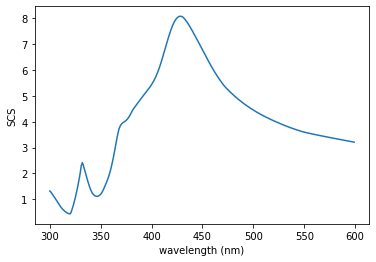

In [13]:
L = np.arange(300, 600, 1)
SCS = []


for i in range(len(L)):
    
    
    lyambda_current = L[i]
    w0_incident_current = 2*pi*r_ext/lyambda_current
    
    n_value, k_value = get_refractive_index(lyambda_current, plasmonic_metal)
    n_plasma_refr_index_current = n_value - 1.j * k_value
    
#     n_plasma_refr_index_current= get_plasma_refr_index(eps_inf_plasma, w_plasma, gamma_plasma, w0_incident_current)
  
    a_m, b_m,  c_m, d_m = get_coefficients(w0_incident_current, n_plasma_refr_index_current, h_ratio, alpha_incident, N_truncation_number, dist_btw_centers)
    if a_m == []:
        print('The system does not converge for this parameters')
        break
        
    res = 0
    for m in range(-N_truncation_number, N_truncation_number + 1):
        
        res = res + np.abs(d_m[m + N_truncation_number]) ** 2
    SCS.append(4 * res[0] / w0_incident_current)

if len(L) == len(SCS):   
    plt.plot(L, SCS)
    
plt.xlabel('wavelength (nm)')
plt.ylabel('SCS')

# plt.savefig('figures/SCS_ext_'+ str(r_ext) +'_r_int_' + str(r_int)+ '.jpg', dpi = 100)  

In [14]:
peaks, _ = find_peaks(SCS)

for i in range(len(peaks)):
    print(L[peaks[i]], ' nm')

332  nm
428  nm
